In [29]:
from torch.utils.data import Dataset
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from random import randint
from augment_functions import random_mask, resize_encoder, augment_sample, augment_sample_random_mask
from sklearn.metrics.pairwise import pairwise_distances

In [30]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [31]:
class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob=0.7):
        self.data = data
        self.mask_prob = mask_prob
        
    def __len__(self):
        return (self.data.shape[0])

    def __getitem__(self, idx):
        x_orig = self.data[idx]
        x = resize_encoder(x_orig)
        masked_x = random_mask(x, mask_prob=self.mask_prob)
        X = augment_sample(x_orig)
        X_prime = augment_sample_random_mask(x_orig, random_mask_prob=self.mask_prob)
        y = idx
        return x_orig, x, masked_x, y, X, X_prime

In [32]:
model = torch.load('barlow_twins_layer.pth', weights_only=False, map_location=DEVICE)
model.eval()

model = model.encoder

BATCH_SIZE = 20
data = torch.load('/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt')
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train:n_train+n_valid]
test_data = data[n_train+n_valid:]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

train_data = (train_data - mean) / std
train_dataset = WeatherBenchDataset(data=train_data, mask_prob=0.7)
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [33]:
def negative_cosine_sim_matrix(embeddings):
    z = F.normalize(embeddings, dim=1)
    sim_matrix = torch.matmul(z, z.T)
    N = sim_matrix.shape[0]
    mask = ~torch.eye(N, dtype=torch.bool, device=sim_matrix.device)
    negative_sims = sim_matrix[mask]
    return negative_sims


In [34]:
cos_sim_mean = []
rand_cos_sim_mean = []
mean_var = []
with torch.no_grad():
    for batch in testloader:
        X = batch[1].to(DEVICE)
        X_prime = batch[2].to(DEVICE)
        embeddings_x, _ = model(X)
        embeddings_x_prime, _ = model(X_prime)

        embeddings_x = embeddings_x.cpu()
        embeddings_x_prime = embeddings_x_prime.cpu()

        cos_sim = F.cosine_similarity(embeddings_x, embeddings_x_prime, dim=1)
        cos_sim_mean.append(cos_sim.mean().item())


        neg_cosine = negative_cosine_sim_matrix(embeddings_x)
        rand_cos_sim_mean.append(neg_cosine.mean().item())

        variance = embeddings_x.var(dim=0)
        mean_var.append(variance.mean().item())

cos_sim, rand_cos_sim, mean_var = np.mean(cos_sim_mean), np.mean(rand_cos_sim_mean), np.mean(mean_var)

print("Mean Cosine similarity:", cos_sim)
print("Negative Mean Cosine similarity:", rand_cos_sim)
print("Mean Variance of Embeddings", mean_var)


Mean Cosine similarity: 0.9983013623800033
Negative Mean Cosine similarity: 0.9710002307199005
Mean Variance of Embeddings 0.1677299458374325


In [35]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
y = batch[3].to(DEVICE)

print(x.shape)

torch.Size([20, 5, 144, 72])


In [36]:
with torch.no_grad():
    embeddings_x, _ = model(x)
    embeddings_masked_x, _ = model(masked_x)

[4.3557253 3.807618  5.069749  3.3299184 2.6086614 2.8994083 6.178544
 5.121703  4.501908  6.678435  4.0083585 4.628195  2.6168005 5.227589
 2.9415562 4.7423043 5.708424  6.1496415 4.9599695 3.357901 ]


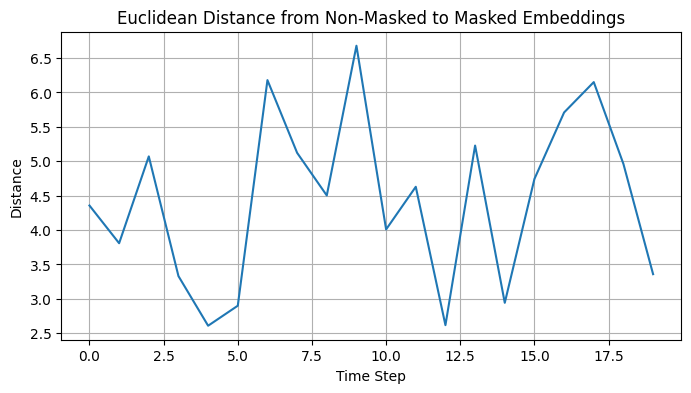

In [37]:
dist = np.linalg.norm(embeddings_x - embeddings_masked_x, axis=1)
print(dist)
plt.figure(figsize=(8, 4))
plt.plot(dist)
plt.title(f'Euclidean Distance from Non-Masked to Masked Embeddings')
plt.xlabel('Time Step')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

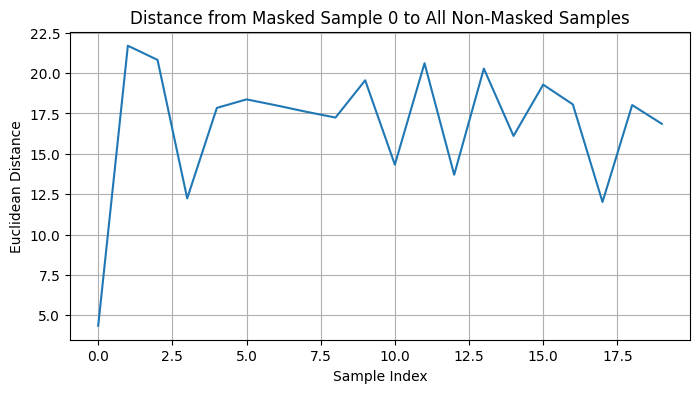

In [38]:
ref_embedding = embeddings_masked_x[0]  # shape: (embedding_dim,)
dist_to_all = np.linalg.norm(embeddings_x - ref_embedding, axis=1)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(dist_to_all)
plt.title('Distance from Masked Sample 0 to All Non-Masked Samples')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean Distance')
plt.grid(True)
plt.show()

In [39]:
embeddings_x = embeddings_x.cpu().numpy()
embeddings_masked_x = embeddings_masked_x.cpu().numpy()
y = y.cpu().numpy()

combined = np.vstack([embeddings_x, embeddings_masked_x])
pca = PCA(n_components = 2)
combined_proj = pca.fit_transform(combined)

x_proj = combined_proj[:len(embeddings_x)]
x_prime_proj = combined_proj[len(embeddings_x):]




df = pd.DataFrame({
    'x': np.concatenate([x_proj[:, 0], x_prime_proj[:, 0]]),
    'y': np.concatenate([x_proj[:, 1], x_prime_proj[:, 1]]),
    'group': ['A'] * BATCH_SIZE + ['B'] * BATCH_SIZE,
    'point_id': list(range(BATCH_SIZE)) * 2
})

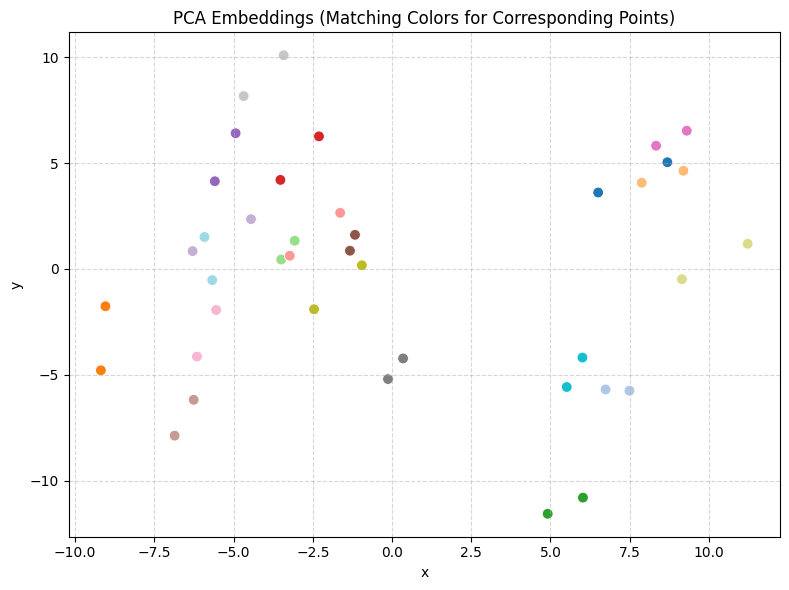

In [40]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='x', y='y', hue='point_id', palette='tab20', s=60)
plt.legend().remove()
plt.title("PCA Embeddings (Matching Colors for Corresponding Points)")
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [41]:
df = pd.DataFrame({
    'x': x_prime_proj[:, 0],
    'y': x_prime_proj[:, 1],
    'labels': y
})

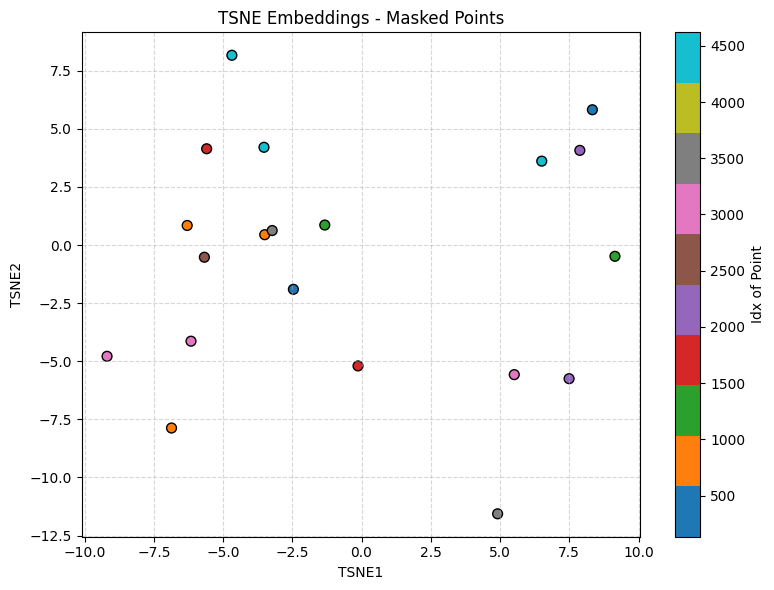

In [42]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['x'], df['y'], c=df['labels'], cmap='tab10', s=50, edgecolors='k')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('TSNE Embeddings - Masked Points')
plt.colorbar(scatter, label='Idx of Point')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
